In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools
import math
import time

import gensim
import numpy as np
import scipy.spatial.distance as dist
from scipy.stats import ttest_ind
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sampl.gsn_api as gsn
import sampl.semantics as sem
import sampl.update as update
import sampl.paradigm_anderson as pa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieval-induced forgetting

In this notebook we use our model to reproduce the retrieval-induced forgetting (RIF) effect described in experiment 1 from Anderson, Bjork, & Bjork (1994, henceforth ABB).

## Setting up the network

We use the same word list as ABB, and we pull inter-word edge weights from a word2vec model trained on Google News. 

In [3]:
google_news_w2v_path = '../data/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [24]:
anderson_words, anderson_graph = pa.anderson_graph(google_news)

In [25]:
sns.set(font_scale=1.6)
sns.set_style('white')

In [26]:
alternative_labels = [''] * len(anderson_words)
alternative_labels[6*0] = 'Fruits'
alternative_labels[6*1] = 'Leather'
alternative_labels[6*2] = 'Trees'
alternative_labels[6*3] = 'Professions'
alternative_labels[6*4] = 'Drinks'
alternative_labels[6*5] = 'Hobbies'
alternative_labels[6*6] = 'Metals'
alternative_labels[6*7] = 'Weapons'
alternative_labels[6*8] = 'Labels'

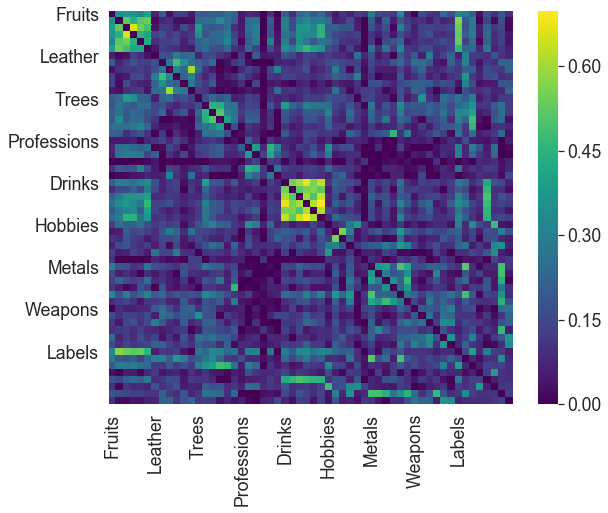

In [27]:
fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(
    anderson_graph.adj, 
    xticklabels=alternative_labels, 
    yticklabels=alternative_labels, 
    cmap='viridis'
)
plt.tight_layout()

## Model parameter search

We use a simple grid search to find model parameters that reproduce the RIF effect from ABB.

In [28]:
y_min_grid = [-.75, -.5, -.4, -.3, -.2, -.1, -.05, -.025, -.01, 0]
y_max_grid = [.75, .5, .4, .3, .2, .1, .05, .025, .01, 0]
dip_center_grid = [.05, .1, .15, .2, .25, .3, .35, .4]
dip_width_grid = [.05, .1, .15, .2, .25, .3, .35, .4]
discount_grid = [.1, .2, .3, .4, .5, .75, .9]

parameter_grid = list(itertools.product(
    y_min_grid, 
    y_max_grid, 
    dip_center_grid, 
    dip_width_grid, 
    discount_grid
))
len(parameter_grid)

44800

In [43]:
def run_with_params(params):
    y_min, y_max, dip_center, dip_width, discount = params
    
    update_grid = update.get_update(
        dip_center=dip_center,
        dip_width=dip_width,
        y_min=y_min,
        y_max=y_max
    )
    result = pa.run_anderson_counterbalanced(
        gsn.GraphOperator(
            graph=copy.deepcopy(copy.deepcopy(anderson_graph)), 
            operate_fx=gsn.operate_recur, 
            update_fx=update_grid,
            discount=discount
        ), 
        n_recalls=3
    )
    return result


def cost_and_weights(result):
    weights = []
    for r in result:
        rif_weights_t2 = pa.rif_weights(
            r['op'].graph, 
            r['practice_list']['rpp'], 
            r['practice_list']['rpm'], 
            r['practice_list']['nrp']
        )
        weights.append(rif_weights_t2)
    cost = np.mean([pa.fit_cost_anderson(w) for w in weights])
    return cost, weights


def calculate_costs(counterbalanced_results):
    costs = []
    weights = []

    for single_results in counterbalanced_results:
        c, w = cost_and_weights(single_results)
        costs.append(c)
        weights.append(w)
    return costs, weights


def parameter_search(grid):
    start = time.process_time()

    costs = []
    for i, params in enumerate(grid):
        result = run_with_params(params)
        costs.append(cost_and_weights(result)[0])
        
        if i % 1000 == 0:
            print(f"{i}/{len(grid)} simulations complete...")

    end = time.process_time()
    print(f"# of simulations: {len(grid)}\t\tTime: {round((end - start) / 60, 2)} minutes")
    return(costs)

In [38]:
my_grid = np.array(parameter_grid)

In [87]:
# N.B.: Takes a while. You probably want to load cached results instead; see below.

costs = parameter_search(my_grid)

0/44800 simulations complete...
250/44800 simulations complete...
500/44800 simulations complete...
750/44800 simulations complete...
1000/44800 simulations complete...
1250/44800 simulations complete...
1500/44800 simulations complete...
1750/44800 simulations complete...
2000/44800 simulations complete...
2250/44800 simulations complete...
2500/44800 simulations complete...
2750/44800 simulations complete...
3000/44800 simulations complete...
3250/44800 simulations complete...
3500/44800 simulations complete...
3750/44800 simulations complete...
4000/44800 simulations complete...
4250/44800 simulations complete...
4500/44800 simulations complete...
4750/44800 simulations complete...
5000/44800 simulations complete...
5250/44800 simulations complete...
5500/44800 simulations complete...
5750/44800 simulations complete...
6000/44800 simulations complete...
6250/44800 simulations complete...
6500/44800 simulations complete...
6750/44800 simulations complete...
7000/44800 simulations com

The cost of each simulation at each point on the parameter grid was the sum of the errors of our result versus the actual result from ABB. Lower costs are better.

Recall proportion was operationalized as the category-to-item edge weight.

In [32]:
# N.B.: Do this only if you also ran the grid search and want to save the results.

#np.save(file='../grid_search_results/costs_anderson.npy', arr=costs)

In [44]:
costs = np.load(file='../grid_search_results/costs_anderson.npy')

## Result 1: the model captures RIF

We visualize the result generated using the parameter set with the lowest cost.

In [45]:
# We do not make the "strong" / "weak" distinction made by ABB, so we take 
# the mean of their results as our target.

strong_rpp = .810
strong_rpm = .403
strong_nrp = .560
weak_rpp = .662
weak_rpm = .347
weak_nrp = .410

rpp_target = np.mean([strong_rpp, weak_rpp])
rpm_target = np.mean([strong_rpm, weak_rpm])
nrp_target = np.mean([strong_nrp, weak_nrp])

In [46]:
def plot_results(weights, op, nmp_label="NMP"):
    sns.set(font_scale=1.6)
    sns.set_style('ticks')
    
    obs = []
    labels = []
    for x in np.concatenate(np.array(weights)[:, 0]):
        obs.append(x)
        labels.append('RP+')
    for x in np.concatenate(np.array(weights)[:, 1]):
        obs.append(x)
        labels.append('RP-')
    for x in np.concatenate(np.array(weights)[:, 2]):
        obs.append(x)
        labels.append('NRP')

    obs.append(rpp_target)
    obs.append(rpm_target)
    obs.append(nrp_target)
    labels.append('RP+')
    labels.append('RP-')
    labels.append('NRP')

    df = pd.DataFrame({
        'Recall proportion': obs,
        'Type': labels,
        'Source': ['SAMPL'] * (len(obs) - 3) + ['Human'] * 3
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.barplot(data=df, y='Recall proportion', x='Type', hue="Source", ax=ax1)
    ax1.set_ylim((0,1))
    ax1.set(xticklabels=['RP+', 'RP-', 'NRP']);
    ax1.set_title("Results")

    xs = np.linspace(0, 1., 101)
    ys = op.update_fx(xs)
    ax2.plot(xs, ys)
    ax2.set_xlabel('Activation strength')
    ax2.set_ylabel('Weight change')
    ax2.set_title(nmp_label)
    ylim = ax2.get_ylim()
    one_percent_y = (ylim[1] - ylim[0]) / 100
    ax2.text(x=0, y=ylim[1] - one_percent_y * 5, s=f"γ = {np.round(op.discount, 2)}")

    plt.tight_layout()
    sns.despine()
    
    return df

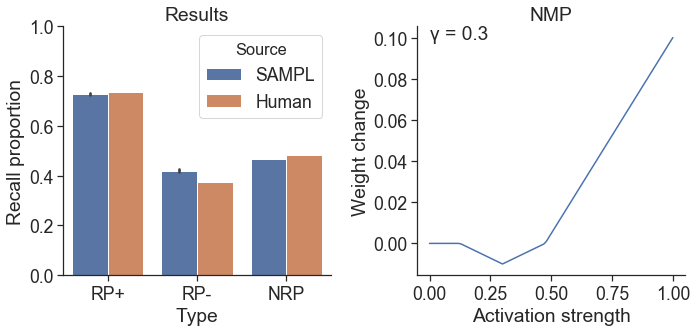

In [49]:
i_win = np.argmin(costs)
params_win = my_grid[i_win]
y_min, y_max, dip_center, dip_width, discount = my_grid[i_win]
result_win = run_with_params(params_win)

cost_win, weights_win = cost_and_weights(result_win)
op_win = result_win[0]['op']

res_df = plot_results(weights_win, op_win)

In [53]:
sim_df = res_df[res_df['Source'] == 'SAMPL']
abb_df = res_df[res_df['Source'] != 'SAMPL']

In [54]:
ttest_ind(
    sim_df[sim_df['Type'] == 'RP-']['Recall proportion'].values, 
    sim_df[sim_df['Type'] == 'NRP']['Recall proportion'].values,
    equal_var=False
)

Ttest_indResult(statistic=-15.224992710894092, pvalue=4.375669421510609e-21)

In [55]:
dof = (
    len(sim_df[sim_df['Type'] == 'RP-']['Recall proportion']) + 
    len(sim_df[sim_df['Type'] == 'NRP']['Recall proportion']) - 2
)
dof

142

In [56]:
(
    np.mean(sim_df[sim_df['Type'] == 'RP-']['Recall proportion'].values) -
    np.mean(sim_df[sim_df['Type'] == 'NRP']['Recall proportion'].values)
)

-0.046851422197019155

In [57]:
(
    np.mean(abb_df[abb_df['Type'] == 'RP-']['Recall proportion'].values) -
    np.mean(abb_df[abb_df['Type'] == 'NRP']['Recall proportion'].values)
)

-0.10999999999999999

In [58]:
params_win

array([-0.01,  0.1 ,  0.3 ,  0.35,  0.3 ])

Examining the adjacency matrix shows that the resulting state of the semantic network is plausible—categorical relationships are maintained, and the largest weight changes are between items and their category labels, consistent with the theorized effects of retrieval practice.

### How does the RIF effect change as we change the parameters of the model?

Below, we visualize how the cost changes as a function of the suppression, enhancement, and discount (gamma) model parameters, as the other model parameters are held constant. Lower cost indicates a better fit of the behavior of the model to the results from ABB.

In [60]:
y_min_param_sets = []
y_min_unique = sorted([y_min] + list(np.linspace(-1, 0, 21)))
for v in y_min_unique:
    y_min_param_sets.append(
        (v, y_max, dip_center, dip_width, discount)
    )
y_min_results = [run_with_params(p) for p in y_min_param_sets]
y_min_costs = calculate_costs(y_min_results)[0]
    
y_max_param_sets = []
y_max_unique = sorted([y_max] + list(np.linspace(0, 1, 21)))
for v in y_max_unique:
    y_max_param_sets.append(
        (y_min, v, dip_center, dip_width, discount)
    )
y_max_results = [run_with_params(p) for p in y_max_param_sets]
y_max_costs = calculate_costs(y_max_results)[0]

discount_param_sets = []
discount_unique = sorted([discount] + list(np.linspace(0, 1, 21)))
for v in discount_unique:
    discount_param_sets.append(
        (y_min, y_max, dip_center, dip_width, v)
    )
discount_results = [run_with_params(p) for p in discount_param_sets]
discount_costs = calculate_costs(discount_results)[0]

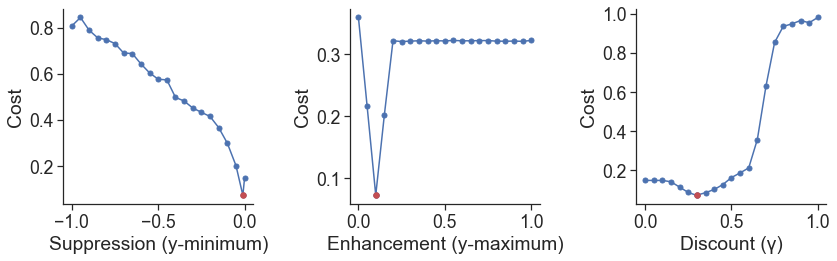

In [62]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
msize=5
ax1.plot(y_min_unique, y_min_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax1.plot(y_min, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax1.set_xlabel('Suppression (y-minimum)')
ax1.set_ylabel('Cost')

ax2.plot(y_max_unique, y_max_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax2.plot(y_max, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax2.set_xlabel('Enhancement (y-maximum)')
ax2.set_ylabel('Cost')

ax3.plot(discount_unique, discount_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax3.plot(discount, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax3.set_xlabel('Discount (γ)')
ax3.set_ylabel('Cost')

plt.tight_layout()
sns.despine()

### What does the final state of the network look like?

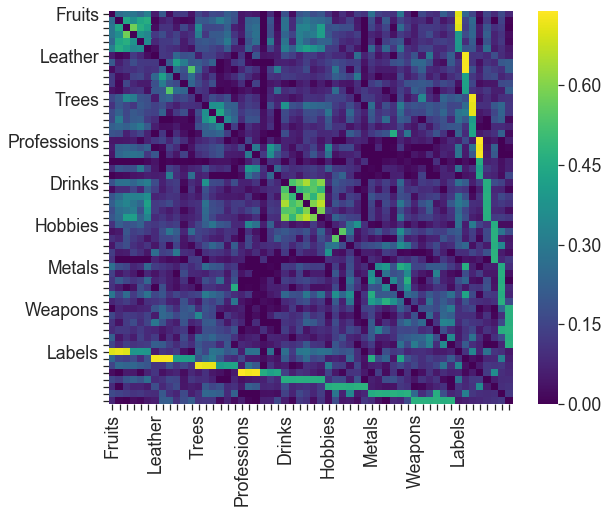

In [63]:
fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(
    op_win.graph.adj, 
    xticklabels=alternative_labels, 
    yticklabels=alternative_labels, 
    cmap='viridis'
)
plt.tight_layout()

## Result 2: suppression is required for human-like results

### Lesioned NMP function

In [64]:
params_win_lesioned = copy.copy(params_win)
params_win_lesioned[0] = 0.0
params_win_lesioned

array([0.  , 0.1 , 0.3 , 0.35, 0.3 ])

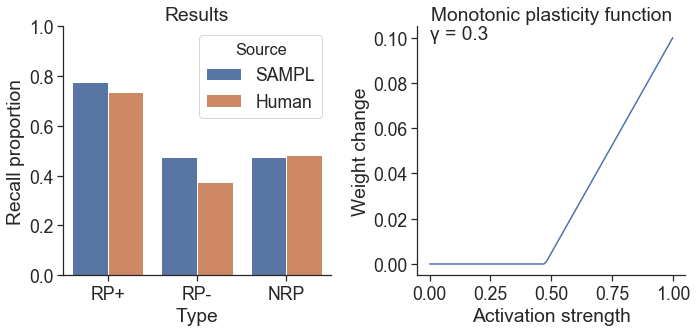

In [65]:
result_win_lesioned = run_with_params(params_win_lesioned)

_, weights_win_lesioned = cost_and_weights(result_win_lesioned)
op_win_lesioned = result_win_lesioned[0]['op']

_ = plot_results(weights_win_lesioned, op_win_lesioned, nmp_label="Monotonic plasticity function")

### Result without inhibition closest to ABB (1994)

Parameter settings without inhibition that create results similar to ABB (1994) show no RIF effect.

,Recall proportion,Type,Source
0,0.725594,RP+,SAMPL
1,0.737756,RP+,SAMPL
2,0.741631,RP+,SAMPL
3,0.725000,RP+,SAMPL
4,0.725000,RP+,SAMPL
5,0.725000,RP+,SAMPL
6,0.725000,RP+,SAMPL
7,0.733332,RP+,SAMPL
8,0.725665,RP+,SAMPL
9,0.725000,RP+,SAMPL


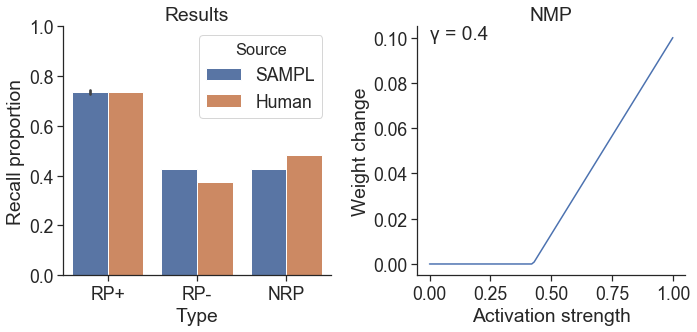

In [66]:
my_grid_no_dip_ix = my_grid[:, 0] == 0
costs_no_dip = np.array(costs)[my_grid_no_dip_ix]
i_win_no_dip = np.argmin(costs_no_dip)
params_win_no_dip = my_grid[my_grid_no_dip_ix][i_win_no_dip]

result_win_no_dip = run_with_params(params_win_no_dip)

_, weights_win_no_dip = cost_and_weights(result_win_no_dip)
op_win_no_dip = result_win_no_dip[0]['op']

plot_results(weights_win_no_dip, op_win_no_dip)

### Result without inhibition with highest RIF effect size

Parameter settings without inhibition that do show a RIF effect do not show human-like patterns of association at the item level.

In [67]:
# Because the earlier weights are not cached (to save memory) this can take a minute

rif_effect_sizes = []
rif_results = []
for params in my_grid[my_grid_no_dip_ix]:
    result = run_with_params(params)
    cost, weights = cost_and_weights(result)
    rpm = np.concatenate(np.array(weights)[:, 1])
    nrp = np.concatenate(np.array(weights)[:, 2])
    rif_effect_sizes.append(np.mean(nrp) - np.mean(rpm))
    rif_results.append(result)

,Recall proportion,Type,Source
0,1.000000,RP+,SAMPL
1,1.000000,RP+,SAMPL
2,1.000000,RP+,SAMPL
3,1.000000,RP+,SAMPL
4,1.000000,RP+,SAMPL
5,1.000000,RP+,SAMPL
6,1.000000,RP+,SAMPL
7,1.000000,RP+,SAMPL
8,1.000000,RP+,SAMPL
9,1.000000,RP+,SAMPL


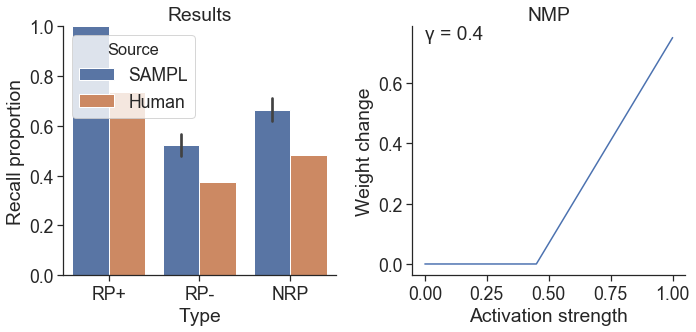

In [68]:
sorted_rif_sizes = sorted(list(enumerate(rif_effect_sizes)), key=lambda x: -x[1])
i_win_rif_size = sorted_rif_sizes[0][0]

_, weights_rif_size_win = cost_and_weights(rif_results[i_win_rif_size])
op_rif_size_win = rif_results[i_win_rif_size][0]['op']

plot_results(weights_rif_size_win, op_rif_size_win)

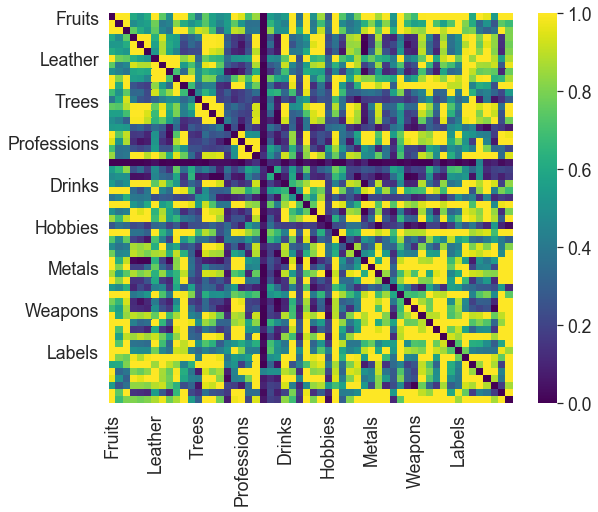

In [69]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(
    op_rif_size_win.graph.adj, 
    xticklabels=alternative_labels, 
    yticklabels=alternative_labels, 
    cmap='viridis'
)
plt.tight_layout()